In [7]:
#| export 
from fastbook import *
from fastai.vision.widgets import *

## Gathering Data

In [2]:
#| hide 
ims = ['http://3.bp.blogspot.com/-S1scRCkI3vY/UHzV2kucsPI/AAAAAAAAA-k/YQ5UzHEm9Ss/s1600/Grizzly%2BBear%2BWildlife.jpg']

In [3]:
dest = 'data/images/grizzly.jpg'
download_url(ims[0], dest)

Path('data/images/grizzly.jpg')

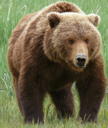

In [4]:
im = Image.open(dest)
im.to_thumb(128,128)

In [8]:
#| export 
device_types = 'laptop','desktop pc','mobile phone'
path = Path('data_devices')

In [6]:
#| export  
if not path.exists():
    path.mkdir()
    for o in device_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_ddg(f'{o}', max_images=100)
        # results = search_images_bing(key, f'{o} bear')
        # download_images(dest, urls=results.attrgot('contentUrl'))
        download_images(dest, urls=results)

In [7]:
#| export 
fns = get_image_files(path)


(#274) [Path('data_devices/desktop pc/18716900-596a-4b7b-b3c3-e13ba59c131a.jpg'),Path('data_devices/desktop pc/6505b8a1-651a-4d8c-9755-771c6aed0315.jpg'),Path('data_devices/desktop pc/d4667354-6527-4602-91bc-3820962f29b3.jpg'),Path('data_devices/desktop pc/e61d91da-5ba1-4691-8790-aa546165ead4.jpeg'),Path('data_devices/desktop pc/980ce41c-bd50-4c0a-8a46-f1fec5b30f1e.png'),Path('data_devices/desktop pc/aede34ef-3f57-4743-81de-55c7b95250e2.jpg'),Path('data_devices/desktop pc/d79a88d0-8d13-43fe-b220-278608361f01.jpg'),Path('data_devices/desktop pc/6e430dcb-2527-4f8d-9135-c5e28e01ab4c.png'),Path('data_devices/desktop pc/d9cb30e4-1880-419a-8a5f-2523aee5835d.jpg'),Path('data_devices/desktop pc/bf175586-8127-413c-aad4-247666b8879e.jpg')...]

In [ ]:
fns

In [8]:
#| export 
failed = verify_images(fns)


(#11) [Path('data_devices/desktop pc/d9cb30e4-1880-419a-8a5f-2523aee5835d.jpg'),Path('data_devices/desktop pc/31a3de39-f326-4dda-b95a-ae3d2295a63f.png'),Path('data_devices/desktop pc/cd37be8a-040b-41ae-93ab-b6565b5c86b4.jpg'),Path('data_devices/mobile phone/dd03f493-1c75-4fbe-8ab9-8347e5aa21cd.jpg'),Path('data_devices/mobile phone/7ff69ee5-d272-47d4-b3e0-dd9a4a591107.jpg'),Path('data_devices/mobile phone/df4a8417-ca0b-4271-9352-b4bed1f5f178.jpg'),Path('data_devices/mobile phone/5013078f-1f08-459c-b187-4b1999e3fcbb.jpg'),Path('data_devices/mobile phone/29f7cd34-9974-4abc-a992-a3415b6f4760.png'),Path('data_devices/mobile phone/b7016122-cb8d-4d40-a37a-f54ca783ab47.jpg'),Path('data_devices/mobile phone/21e9155b-3f6f-4783-b80b-3105500eaaef.jpg')...]

In [ ]:
failed

In [9]:
#| export 
failed.map(Path.unlink);


## From Data to DataLoaders

In [10]:
#| export 
devices = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [11]:
#| export 
dls = devices.dataloaders(path)

/home/demonhunter/mambaforge/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


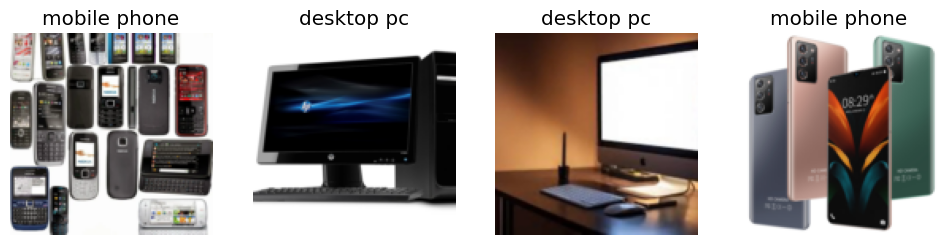

In [12]:
dls.valid.show_batch(max_n=4, nrows=1)

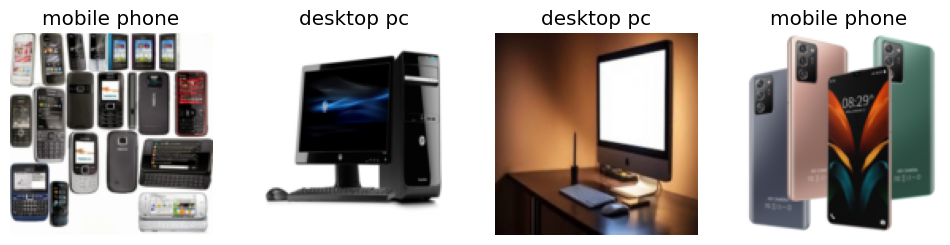

In [13]:
devices = devices.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = devices.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

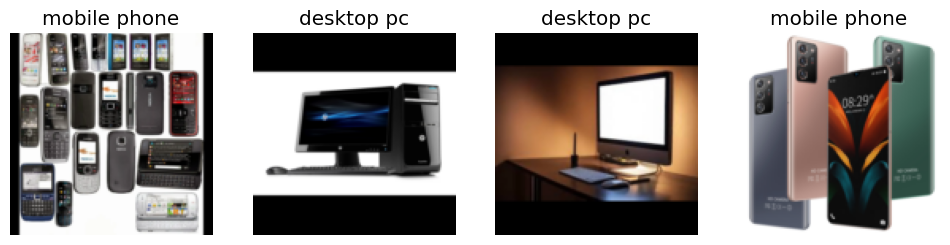

In [14]:
devices = devices.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = devices.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

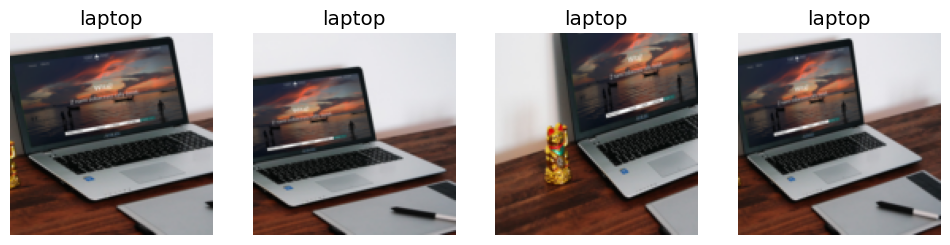

In [15]:
devices = devices.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = devices.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

### Data Augmentation

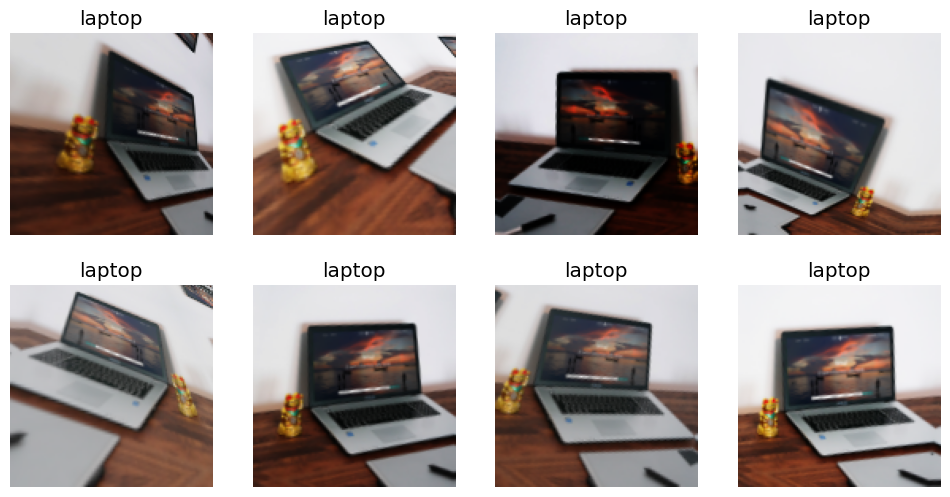

In [16]:
devices = devices.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = devices.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

## Training Your Model, and Using It to Clean Your Data

In [17]:
#| export 
devices = devices.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = devices.dataloaders(path)

In [18]:
#| export 
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

/home/demonhunter/mambaforge/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


/home/demonhunter/mambaforge/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


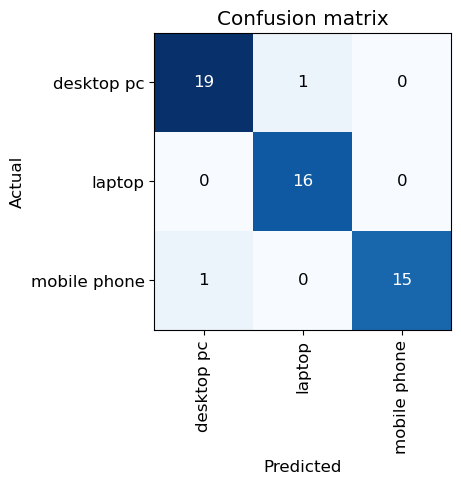

In [34]:
#| export 
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

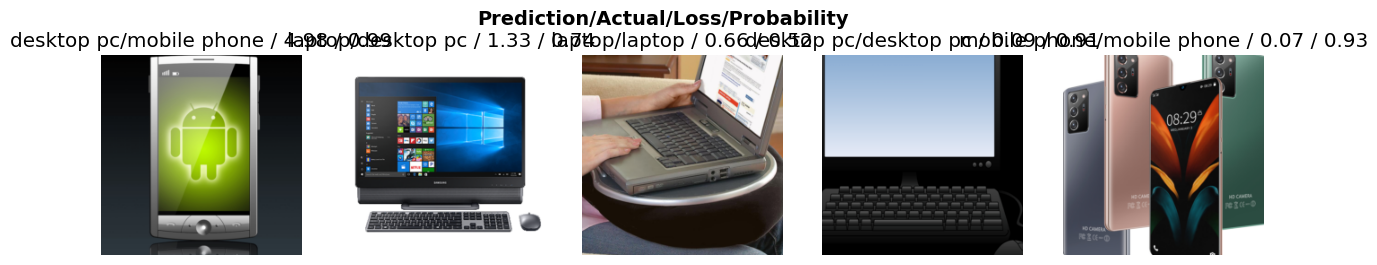

In [35]:
interp.plot_top_losses(5, nrows=1)

In [36]:
cleaner = ImageClassifierCleaner(learn)
cleaner

FileNotFoundError: Caught FileNotFoundError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/demonhunter/mambaforge/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/demonhunter/mambaforge/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 41, in fetch
    data = next(self.dataset_iter)
  File "/home/demonhunter/mambaforge/lib/python3.10/site-packages/fastai/data/load.py", line 138, in create_batches
    yield from map(self.do_batch, self.chunkify(res))
  File "/home/demonhunter/mambaforge/lib/python3.10/site-packages/fastcore/basics.py", line 230, in chunked
    res = list(itertools.islice(it, chunk_sz))
  File "/home/demonhunter/mambaforge/lib/python3.10/site-packages/fastai/data/load.py", line 153, in do_item
    try: return self.after_item(self.create_item(s))
  File "/home/demonhunter/mambaforge/lib/python3.10/site-packages/fastai/data/load.py", line 160, in create_item
    if self.indexed: return self.dataset[s or 0]
  File "/home/demonhunter/mambaforge/lib/python3.10/site-packages/fastai/data/core.py", line 458, in __getitem__
    res = tuple([tl[it] for tl in self.tls])
  File "/home/demonhunter/mambaforge/lib/python3.10/site-packages/fastai/data/core.py", line 458, in <listcomp>
    res = tuple([tl[it] for tl in self.tls])
  File "/home/demonhunter/mambaforge/lib/python3.10/site-packages/fastai/data/core.py", line 417, in __getitem__
    return self._after_item(res) if is_indexer(idx) else res.map(self._after_item)
  File "/home/demonhunter/mambaforge/lib/python3.10/site-packages/fastai/data/core.py", line 377, in _after_item
    def _after_item(self, o): return self.tfms(o)
  File "/home/demonhunter/mambaforge/lib/python3.10/site-packages/fastcore/transform.py", line 208, in __call__
    def __call__(self, o): return compose_tfms(o, tfms=self.fs, split_idx=self.split_idx)
  File "/home/demonhunter/mambaforge/lib/python3.10/site-packages/fastcore/transform.py", line 158, in compose_tfms
    x = f(x, **kwargs)
  File "/home/demonhunter/mambaforge/lib/python3.10/site-packages/fastcore/transform.py", line 81, in __call__
    def __call__(self, x, **kwargs): return self._call('encodes', x, **kwargs)
  File "/home/demonhunter/mambaforge/lib/python3.10/site-packages/fastcore/transform.py", line 91, in _call
    return self._do_call(getattr(self, fn), x, **kwargs)
  File "/home/demonhunter/mambaforge/lib/python3.10/site-packages/fastcore/transform.py", line 97, in _do_call
    return retain_type(f(x, **kwargs), x, ret)
  File "/home/demonhunter/mambaforge/lib/python3.10/site-packages/fastcore/dispatch.py", line 120, in __call__
    return f(*args, **kwargs)
  File "/home/demonhunter/mambaforge/lib/python3.10/site-packages/fastai/vision/core.py", line 125, in create
    return cls(load_image(fn, **merge(cls._open_args, kwargs)))
  File "/home/demonhunter/mambaforge/lib/python3.10/site-packages/fastai/vision/core.py", line 98, in load_image
    im = Image.open(fn)
  File "/home/demonhunter/mambaforge/lib/python3.10/site-packages/PIL/Image.py", line 3227, in open
    fp = builtins.open(filename, "rb")
FileNotFoundError: [Errno 2] No such file or directory: '/home/demonhunter/projects/device_detector/data_devices/desktop pc/72ab7c02-cdf2-47a7-8528-a3fa5ee8251b.jpg'


In [32]:
#hide
# for idx in cleaner.delete(): cleaner.fns[idx].unlink()
# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

## Turning Your Model into an Online Application

### Using the Model for Inference

In [23]:
#| export 
learn.export()

In [9]:
#| export 
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [13]:
#| export 
learn_inf = load_learner(path/'export.pkl')

In [19]:
#| export 
query02 = "dell inspiron"
urls = search_images_ddg(query02, max_images = 5 )
dest = f'data_test/{query02}.jpg'
download_url(urls[1], dest)
learn_inf.predict(dest)

('laptop', tensor(1), tensor([6.7894e-02, 9.3190e-01, 2.0912e-04]))

In [12]:
learn_inf.dls.vocab

['desktop pc', 'laptop', 'mobile phone']

### Creating a Notebook App from the Model

In [ ]:
btn_upload = widgets.FileUpload()
btn_upload

In [ ]:
#hide
# For the book, we can't actually click an upload button, so we fake it
btn_upload = SimpleNamespace(data = ['images/grizzly.jpg'])

In [ ]:
img = PILImage.create(btn_upload.data[-1])

In [ ]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

In [ ]:
pred,pred_idx,probs = learn_inf.predict(img)

In [ ]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

In [ ]:
btn_run = widgets.Button(description='Classify')
btn_run

In [ ]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [ ]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [ ]:
VBox([widgets.Label('Select your bear!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

### Turning Your Notebook into a Real App

In [ ]:
#hide
# !pip install voila
# !jupyter serverextension enable --sys-prefix voila 

### Deploying your app

## How to Avoid Disaster

### Unforeseen Consequences and Feedback Loops

## Get Writing!

## Questionnaire

1. Provide an example of where the bear classification model might work poorly in production, due to structural or style differences in the training data.
1. Where do text models currently have a major deficiency?
1. What are possible negative societal implications of text generation models?
1. In situations where a model might make mistakes, and those mistakes could be harmful, what is a good alternative to automating a process?
1. What kind of tabular data is deep learning particularly good at?
1. What's a key downside of directly using a deep learning model for recommendation systems?
1. What are the steps of the Drivetrain Approach?
1. How do the steps of the Drivetrain Approach map to a recommendation system?
1. Create an image recognition model using data you curate, and deploy it on the web.
1. What is `DataLoaders`?
1. What four things do we need to tell fastai to create `DataLoaders`?
1. What does the `splitter` parameter to `DataBlock` do?
1. How do we ensure a random split always gives the same validation set?
1. What letters are often used to signify the independent and dependent variables?
1. What's the difference between the crop, pad, and squish resize approaches? When might you choose one over the others?
1. What is data augmentation? Why is it needed?
1. What is the difference between `item_tfms` and `batch_tfms`?
1. What is a confusion matrix?
1. What does `export` save?
1. What is it called when we use a model for getting predictions, instead of training?
1. What are IPython widgets?
1. When might you want to use CPU for deployment? When might GPU be better?
1. What are the downsides of deploying your app to a server, instead of to a client (or edge) device such as a phone or PC?
1. What are three examples of problems that could occur when rolling out a bear warning system in practice?
1. What is "out-of-domain data"?
1. What is "domain shift"?
1. What are the three steps in the deployment process?

### Further Research

1. Consider how the Drivetrain Approach maps to a project or problem you're interested in.
1. When might it be best to avoid certain types of data augmentation?
1. For a project you're interested in applying deep learning to, consider the thought experiment "What would happen if it went really, really well?"
1. Start a blog, and write your first blog post. For instance, write about what you think deep learning might be useful for in a domain you're interested in.